<a href="https://colab.research.google.com/github/yagel2/TDS_NYC_Airbnb/blob/main/TDS_Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TDS Assignment 2: Advanced Model Analysis, Optimization and Conclusions**
### **Course:** Tabular Data Science Exercise 2
### **Author:** Yagel Alankry and Ido Keren


Load imports and data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

!wget  --no-clobber https://raw.githubusercontent.com/yagel2/TDS_NYC_Airbnb/main/AB_NYC_2019.csv

df = pd.read_csv('Final_Project/Datasets/AB_NYC_2019.csv')

File ‘AB_NYC_2019.csv’ already there; not retrieving.



**Recall: our regression model was the following**

Data preprocessing:

In [ ]:
# Fill missing values in 'reviews_per_month' by reassigning the column directly
olddataset = df.copy()
olddataset['reviews_per_month'] = olddataset['reviews_per_month'].fillna(0)

# Drop rows with missing values in the 'price' column
olddataset = olddataset.dropna(subset=['price'])

# One-hot encoding
olddataset = pd.get_dummies(olddataset, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Feature matrix (X) and target vector (y)
X = olddataset[['minimum_nights', 'number_of_reviews', 'reviews_per_month',
        'availability_365', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Queens',
        'room_type_Private room', 'room_type_Shared room']]
y = olddataset['price']

Split the data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the model:

In [ ]:
xgb_model = XGBRegressor()

# Train and make predictions
y_pred = xgb_model.fit(X_train, y_train).predict(X_test)
y_train_pred = xgb_model.fit(X_train, y_train).predict(X_train)

Plot the result:

<Axes: title={'center': 'Predicted vs. Actual Prices'}, xlabel='Predicted Price ($)', ylabel='Actual Price ($)'>

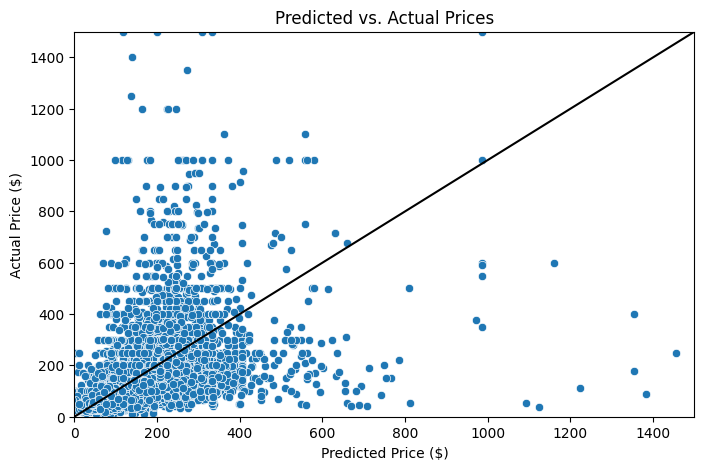

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax)
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Actual Price ($)')
plt.ylim(0, 1500)
plt.xlim(0, 1500)
ax.set_title('Predicted vs. Actual Prices')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='black')

**1. Error Analysis Conclution and Work Plan.**

The first obvious tests we have made are the mean absolute error, mean squared error and r^2 score.

In [ ]:
maeold = mean_absolute_error(y_test, y_pred)
mseold = mean_squared_error(y_test, y_pred)
r2old = r2_score(y_test, y_pred)
pearson_old, _ = pearsonr(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {maeold}")
print(f"Mean Squared Error (MSE): {mseold}")
print(f"R² Score: {r2old}")
print(f"Pearson correlation: {pearson_old}")

Mean Absolute Error (MAE): 71.35013580322266
Mean Squared Error (MSE): 48278.375
R² Score: -0.09132671356201172
Pearson correlation: 0.2664610733301741


We saw our results were very bad, the negative r^2 score reveals it would have been better to use the average price to predict, our guess is the model is overfitting. to check we will test the same on our training set:

In [ ]:
mae = mean_absolute_error(y_train, y_train_pred)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 64.36627960205078
Mean Squared Error (MSE): 34114.3515625
R² Score: 0.4409882426261902


We see our model does work significantly better on our training set so it's safe to conclude our model does overfit.

Next, we evaluated our features importance in the model. and saw availability_365, room_type_private room and neighbourhood_group_Blooklyn being the most influential:

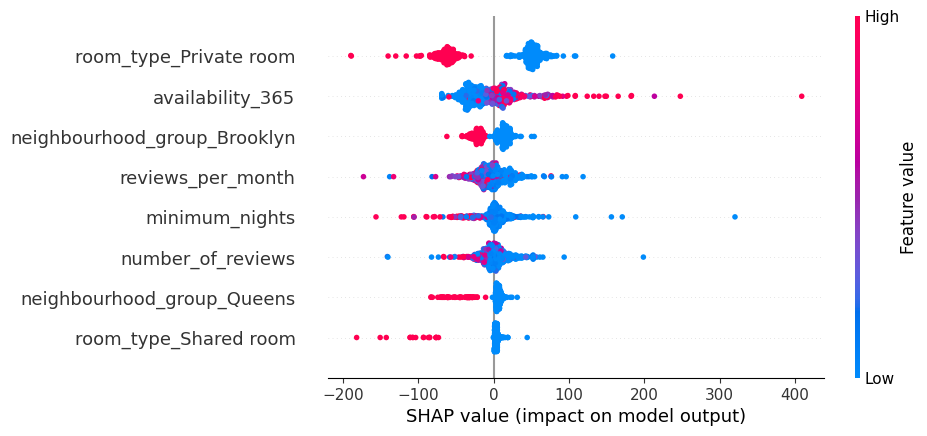

In [ ]:
# Get a sample of values
shap_sample = X_train.sample(500)

# Create an explainer using the trained XGBoost model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the training data (or you can use X_test)
shap_values = explainer(shap_sample)

# Plot summary of SHAP values for the features
shap.plots.beeswarm(shap_values)

This gives us an idea on what feature should and shouldn't be on our model, a look into the relation between price and other featutes could strenthan this claim

<Axes: >

<Figure size 1200x800 with 0 Axes>

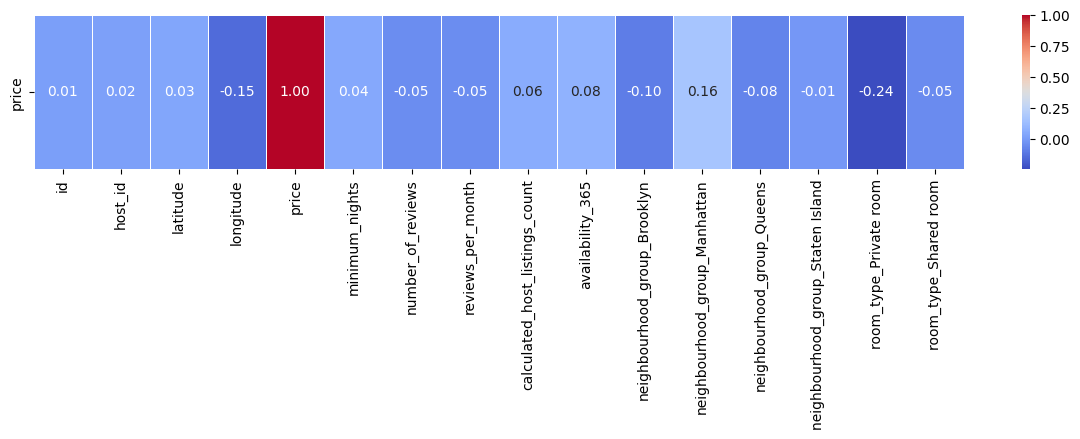

In [ ]:
plt.figure(figsize=(12, 8))

olddataset = olddataset.select_dtypes(include=['number', 'bool'])  # Select only numeric columns


dataset_corr = olddataset.corr(method="pearson").loc[["price"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dataset_corr, annot=True, fmt='.2f', cmap="coolwarm", cbar=True, linewidths=0.5,ax=ax)

We see not only brooklyn is an important feature but all location based features have releavance. also shared room really does tell a lot less than private room like we expected.

Our work plan: deal with the overfitting, focus on the more important features both by shap value and by correlation with price.

**2. Improving Model Performance**

In [ ]:
# Fill missing values in 'reviews_per_month' by reassigning the column directly
dataset = df.copy()

# Drop rows with missing values in the 'price' column
dataset = dataset.dropna(subset=['price'])

# One-hot encoding
dataset = pd.get_dummies(dataset, columns=['room_type'], drop_first=True)

HyperParameter Tuning- we saw that the model overfit, to deal with that we will limit the maximum depth allowed in the decision tree to 2.

In [ ]:
xgb_model = XGBRegressor(max_depth=2)

Feature Engineering- we saw our shap result as well as the correlation between price and the other features.

Our first observation was about the importance of the location when its manhatten or brooklyn, yet less important for other neighbourhoods. this could be because those neighbourhoods our closer to times square- the city center. instead of using the neighbourhood we will calculate a feature for distance from the city center.

In [ ]:
# Define the city center coordinates (Times Square)
city_center_lat = 40.7580
city_center_lon = -73.9855

# Calculate Euclidean distance to the city center
dataset['distance_to_center'] = np.sqrt(
    (dataset['latitude'] - city_center_lat)**2 + (dataset['longitude'] - city_center_lon)**2
)

Next, we will try to create a more significant feature from each feate on its own. we will calculate how many days an airbnb was available but rather then per year we will count the total days. we will do this by calculating how many months the airbnb was for sale, and we will calculate this using the reviews per month and total reviews features.

In [ ]:
dataset['months_for_sale'] = (dataset['reviews_per_month'] / dataset['number_of_reviews'])
dataset['availability_ever'] = (dataset['availability_365'] / 12 * dataset['months_for_sale'])

Lastly, we will remove features thatwere deemed not important enough for our model or without enough correlation. those are number_of_reviews, minimum_nights, and the neighbourhood group. and add our new features we created.

In [ ]:
X = dataset[['availability_365', 'availability_ever', 'reviews_per_month',
             'room_type_Private room', 'room_type_Shared room', 'distance_to_center']]

y = dataset['price']

Handling missing data- first we will check whay data is missing.

In [ ]:
X.isna().sum()

,0
availability_365,0
availability_ever,10052
reviews_per_month,10052
room_type_Private room,0
room_type_Shared room,0
distance_to_center,0


The review per month and availability ever are missing, we will fill them with the mean.

In [ ]:
dataset['availability_ever'] = dataset['availability_ever'].fillna(dataset['availability_ever'].mean())
dataset['reviews_per_month'] = dataset['reviews_per_month'].fillna(dataset['reviews_per_month'].mean())

**The Updated Model**

Split the data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Train the model:

In [ ]:
# Train and make predictions
y_pred = xgb_model.fit(X_train, y_train).predict(X_test)
y_train_pred = xgb_model.fit(X_train, y_train).predict(X_train)

**3. Analyzing the Improved Model**

**Feature Importance:** To understand which features contribute the most to the model's predictions, we use SHAP. Below, we generate a SHAP summary plot to visualize feature impacts.

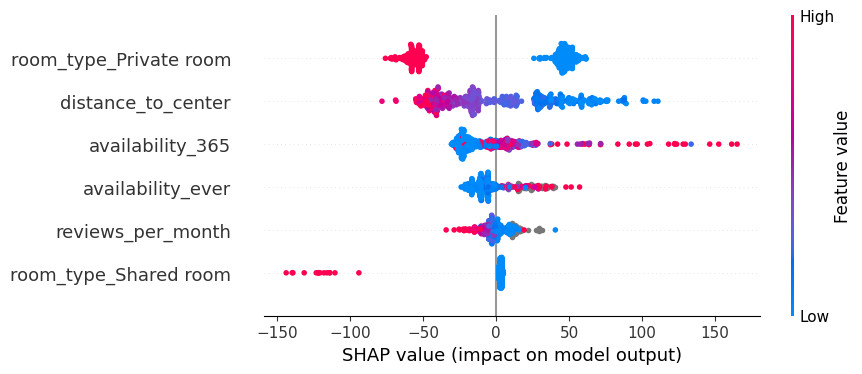

In [ ]:
shap_sample = X_train.sample(500, random_state=42)

# Create SHAP explainer using the trained model
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values
shap_values = explainer(shap_sample)

# Generate SHAP summary plot (beeswarm plot)
shap.plots.beeswarm(shap_values)

**Model Performance Explanation:** To evaluate and compare the improved model's performance against the baseline, we calculate the following metrics: Mean Absolute Error (MAE), Mean Squared Error (MSE), R² score, and Pearson Correlation. A lower MAE and MSE, along with a higher R² score and Pearson Correlation, indicates better model performance.

In [ ]:
from scipy.stats import pearsonr

# Improved model metrics
mae_new = mean_absolute_error(y_test, y_pred)
mse_new = mean_squared_error(y_test, y_pred)
r2_new = r2_score(y_test, y_pred)
pearson_new, _ = pearsonr(y_test, y_pred)

# Print metrics comparison as a table
metrics_comparison = pd.DataFrame({
    'Metric': ['MAE', 'MSE', 'R²', 'Pearson'],
    'Baseline': [maeold, mseold, r2old, pearson_old],
    'Improved Model': [mae_new, mse_new, r2_new, pearson_new]
})

print(metrics_comparison)

    Metric      Baseline  Improved Model
0      MAE     71.350136       66.398018
1      MSE  48278.375000    37935.890625
2       R²     -0.091327        0.142464
3  Pearson      0.266461        0.378020


**Visualization:** We use visualizations to better understand model improvements and feature contributions. The scatter plot below compares predicted vs. actual values, while the bar plot highlights the most important features based on SHAP values.

Scatter Plot: Predicted vs. Actual

<Axes: title={'center': 'Predicted vs. Actual Prices'}, xlabel='Predicted Price ($)', ylabel='Actual Price ($)'>

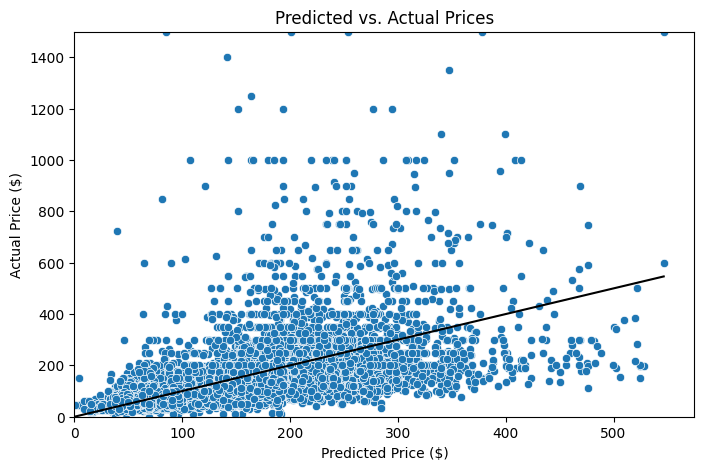

In [ ]:
# Scatter plot for predicted vs actual values
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax)
ax.set_xlabel('Predicted Price ($)')
ax.set_ylabel('Actual Price ($)')
plt.ylim(0, 1500)
plt.xlim(0, 575)
ax.set_title('Predicted vs. Actual Prices')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='black')


Feature Importance Bar Plot:

<ipython-input-85-bd3f682f02c9>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')


Top 5 Most Influential Features:
                  Feature  Importance
0        availability_365    2.251370
3  room_type_Private room    1.522703
1       availability_ever    0.849406
4   room_type_Shared room    0.765996
5      distance_to_center    0.151214


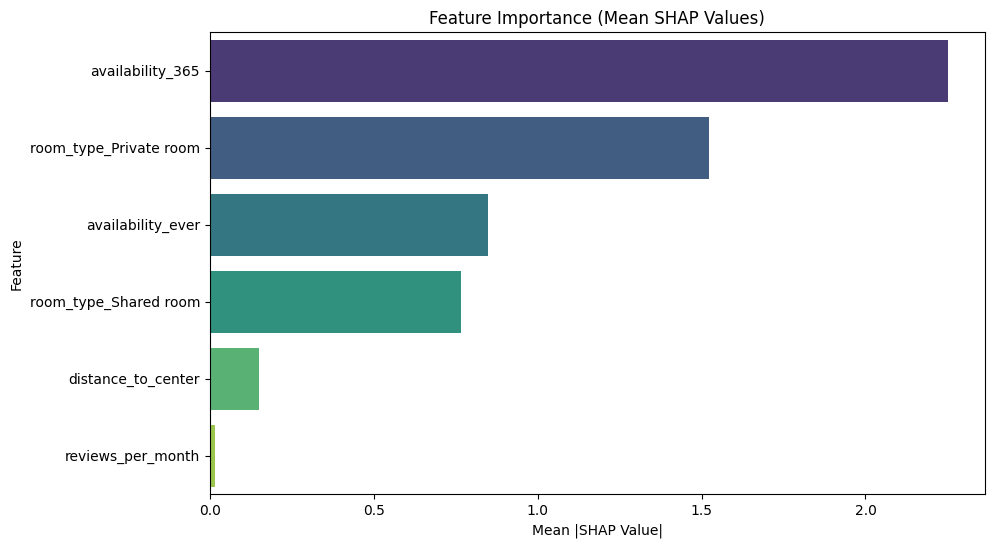

In [ ]:
# Calculate mean absolute SHAP values for features
shap_importance = shap_values.values.mean(axis=0)

# Create DataFrame of feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(shap_importance)
}).sort_values(by='Importance', ascending=False)

# Bar plot for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance (Mean SHAP Values)')
plt.xlabel('Mean |SHAP Value|')
plt.ylabel('Feature')

# Highlight key features driving predictions
print("Top 5 Most Influential Features:")
print(feature_importance.head(5))
plt.show()

**4. Drawing Conclusions About the Data & Creative Applications**

**Analyzing what the improved model reveals about the data**

The SHAP feature importance analysis reveals the following insights:

1. **availability_365 (Importance: 2.25)**  
   - This is the most influential feature, indicating that the number of days a property is available in a year significantly affects pricing.  
   - Properties with higher availability may attract more short-term renters, but they might need competitive pricing due to higher supply.

2. **room_type_Private room (Importance: 1.52)**  
   - Private rooms are a major determinant of pricing. This feature indicates that properties with this room type are priced differently (often lower) compared to entire homes or apartments.  

3. **availability_ever (Importance: 0.85)**  
   - A surprising finding is the importance of how often a property has been available historically. This could correlate with the property's desirability or its owner's rental strategy (e.g., seasonal or selective renting).

4. **room_type_Shared room (Importance: 0.76)**  
   - Shared rooms are also influential, with their lower pricing affecting the overall dataset's price trends. This highlights the need to segment listings by room type when analyzing pricing.

5. **distance_to_center (Importance: 0.15)**  
   - While it has the lowest SHAP importance among the top 5, distance to the city center still plays a role in pricing. Properties closer to the center tend to be priced higher, though its relatively low importance suggests that other factors, like availability and room type, overshadow it.


Biases or Trends

* Room Type Trends: Listings with private rooms and shared rooms dominate the pricing model, indicating that market dynamics are driven by these budget-friendly options rather than premium listings.
* Availability Bias: Availability metrics (e.g., availability_365 and availability_ever) dominate, implying that consistent availability is a key driver of pricing success, likely due to increased exposure to potential renters.
* Location Influence: The lower importance of distance_to_center is surprising, especially for urban markets. This could imply that renters prioritize affordability or unique accommodations over central locations.

Data Insights:

* Surprising Findings:

  Availability metrics dominate over location: While proximity to city centers traditionally influences pricing, this dataset suggests that hosts who optimize availability gain a more significant advantage.
  Room type variability: Private rooms are more influential than entire homes or shared rooms, possibly indicating strong demand for mid-range pricing.

* Potential Bias:

  The dataset may underrepresent luxury listings or properties in prime locations, which could explain the lower influence of distance_to_center.

**Communicating Insights**

Hosts and Property Managers - Emphasize the importance of maximizing availability and strategically pricing private rooms to attract mid-budget travelers.

Travel Platforms - Suggest optimizing search algorithms to weigh room type and availability more heavily, ensuring better visibility for frequently available listings.

Urban Planners - Explore how availability-based competition influences neighborhood affordability and the impact of shared room listings on local markets.

**Proposed Applications**

1.   Real-World Use Cases:
 * Dynamic Pricing Tools: Build predictive models that suggest optimal pricing based on availability, room type, and other influential factors to maximize occupancy rates.
 * Location-agnostic Marketing: For properties further from city centers, platforms could create marketing campaigns to emphasize unique features or value for money.

2.   Predictive Tools for Stakeholders:
 * Develop tools for property owners to forecast earnings based on their availability schedules, allowing better planning and investment strategies.
 * Create dashboards for market trend analysis, helping property managers track demand patterns by room type and availability metrics.

3. External Inspirations:
 *   Airbnb Market Analysis Notebooks: Similar studies have highlighted the impact of room types on pricing dynamics. Leveraging ideas from Inside Airbnb can provide additional insights into availability's role in urban areas.
 *   Tourism Economics Papers: Referencing works on tourism demand elasticity and accommodation pricing strategies can inspire new approaches to pricing model optimization.